### Go Through The Code

In [2]:
from scapy.all import rdpcap, IP, TCP, UDP, ICMP, Raw, IPv6
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
pcap_file = "0.pcap"
try:
    packets = rdpcap(pcap_file)
except FileNotFoundError:
    print(f"File {pcap_file} not found")

In [4]:
total_data = 0
total_packets = 0
packet_sizes = []
src_dst_pairs = defaultdict(int)
src_flows = defaultdict(int)
dst_flows = defaultdict(int)

In [5]:
for packet in packets:
    total_packets += 1
    pkt_len = len(packet)
    packet_sizes.append(pkt_len)
    total_data += pkt_len

    if IP in packet or IPv6 in packet:
        # Extract source and destination IPs and ports
        if IP in packet:
            src_ip = packet[IP].src
            dst_ip = packet[IP].dst
        else:
            src_ip = packet[IPv6].src
            dst_ip = packet[IPv6].dst

        src_port = packet[TCP].sport if TCP in packet else (packet[UDP].sport if UDP in packet else None)
        dst_port = packet[TCP].dport if TCP in packet else (packet[UDP].dport if UDP in packet else None)
        
        # Update unique source-destination pairs
        if src_port and dst_port:
            src_dst_pairs[f"{src_ip}:{src_port} -> {dst_ip}:{dst_port}"] += pkt_len
        
        # Update flow counts for source and destination IPs
        src_flows[src_ip] += 1
        dst_flows[dst_ip] += 1


--- Metrics ---
Total data transferred: 364641870 bytes
Total packets transferred: 805995
Min packet size: 42 bytes
Max packet size: 1514 bytes
Average packet size: 452.41 bytes

--- Packet Size Distribution Percentiles ---
50th percentile: 106.0 bytes
75th percentile: 868.0 bytes
90th percentile: 1514.0 bytes
95th percentile: 1514.0 bytes
99th percentile: 1514.0 bytes

Most packets lie between 60.0 and 868.0 bytes

Source-Destination pair with most data: 172.16.133.95:49358 -> 157.56.240.102:443 (17342229 bytes)


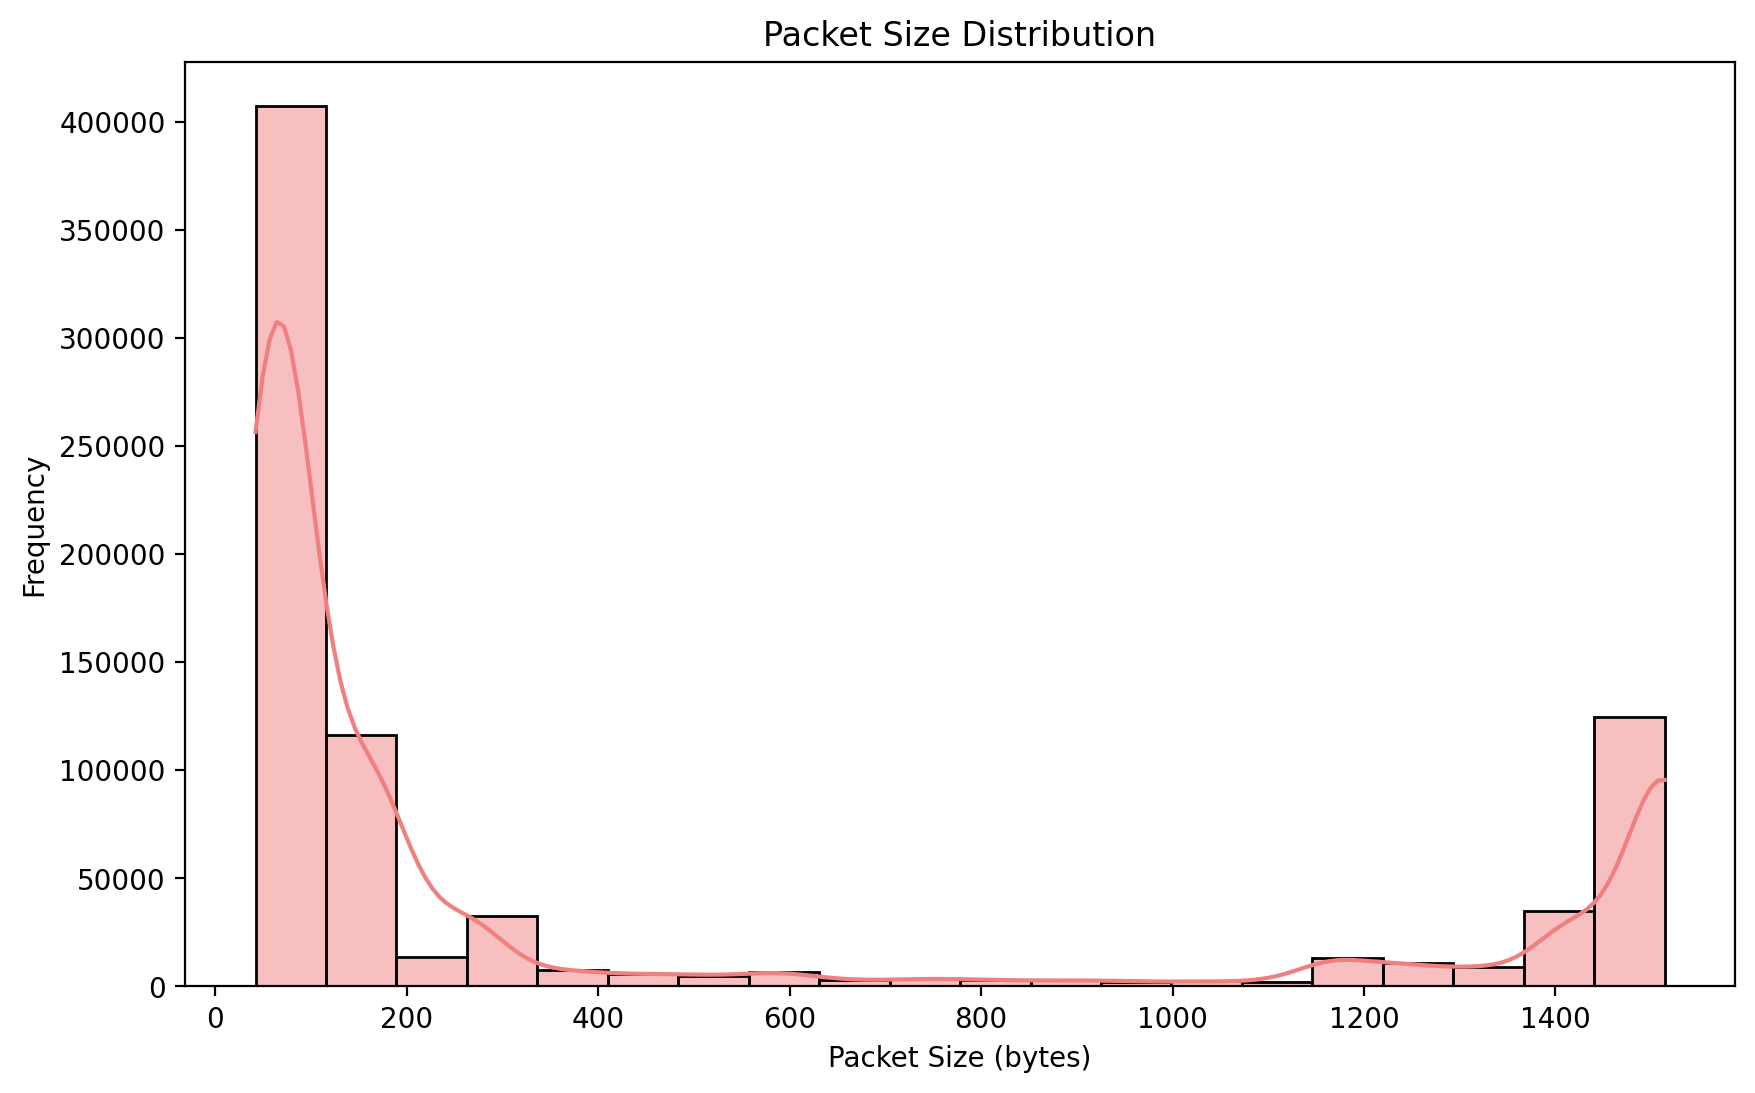

In [13]:
min_pkt_size = min(packet_sizes) if packet_sizes else 0
max_pkt_size = max(packet_sizes) if packet_sizes else 0
avg_pkt_size = sum(packet_sizes) / len(packet_sizes) if packet_sizes else 0

print("\n--- Metrics ---")
print(f"Total data transferred: {total_data} bytes")
print(f"Total packets transferred: {total_packets}")
print(f"Min packet size: {min_pkt_size} bytes")
print(f"Max packet size: {max_pkt_size} bytes")
print(f"Average packet size: {avg_pkt_size:.2f} bytes")

# Save packet size distribution plot using seaborn
plt.figure(figsize=(10, 6))
sns.histplot(packet_sizes, kde=True, bins=20, edgecolor="black", color="lightcoral")
plt.title("Packet Size Distribution")
plt.xlabel("Packet Size (bytes)")
plt.ylabel("Frequency")
plt.savefig("packet_size_distribution.png", dpi=600)

# Describe the distribution using percentiles
percentiles = [50, 75, 90, 95, 99]
percentile_values = {p: np.percentile(packet_sizes, p) for p in percentiles}

print("\n--- Packet Size Distribution Percentiles ---")
for p, value in percentile_values.items():
    print(f"{p}th percentile: {value} bytes")

# Determine the data size range where most packets lie
most_packets_range = (np.percentile(packet_sizes, 25), np.percentile(packet_sizes, 75))
print(f"\nMost packets lie between {most_packets_range[0]} and {most_packets_range[1]} bytes")

# Save metrics to CSV
with open("./Logs/packet_metrics.txt", "w") as txtfile:
    txtfile.write(f"Total data transferred (bytes): {total_data}\n")
    txtfile.write(f"Total packets transferred: {total_packets}\n")
    txtfile.write(f"Min packet size (bytes): {min_pkt_size}\n")
    txtfile.write(f"Max packet size (bytes): {max_pkt_size}\n")
    txtfile.write(f"Average packet size (bytes): {avg_pkt_size:.2f}\n")

# Save unique source-destination pairs and flows to JSON
with open("./JSON/packet_flows.json", "w") as jsonfile:
    json.dump(src_dst_pairs, jsonfile, indent=4)

# Source-destination pair with the most data
if src_dst_pairs:
    max_data_pair = max(src_dst_pairs, key=src_dst_pairs.get)
    print(f"\nSource-Destination pair with most data: {max_data_pair} ({src_dst_pairs[max_data_pair]} bytes)")

### Unique Connections sorted by the number of connections

In [7]:
sorted_src_dst_pairs = dict(sorted(src_dst_pairs.items(), key=lambda x: x[1], reverse=True))

In [8]:
with open("./JSON/packet_flows.json", "w") as jsonfile:
    json.dump(sorted_src_dst_pairs, jsonfile, indent=4)

### Source Flow Dictionary

In [9]:
sorted_src_flows = dict(sorted(src_flows.items(), key=lambda x: x[1], reverse=True))
with open("./JSON/src_flows.json", "w") as jsonfile:
    json.dump(sorted_src_flows, jsonfile, indent=4)

In [10]:
sorted_dst_flows = dict(sorted(dst_flows.items(), key=lambda x: x[1], reverse=True))
with open("./JSON/dst_flows.json", "w") as jsonfile:
    json.dump(sorted_dst_flows, jsonfile, indent=4)